# Problem Set 2

In [1]:
#Let there be np.light
import numpy as np
import pylab as plt
import pickle as pkl
import scipy.optimize

In [2]:
#Extracting data
# Dear all: Get this pickle file from the discord server!
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`

In [3]:
#Constructing fitter
def designfit(x_array,y_array,sigma_array,*design):
    N = len(design) #number of variational parameters
    
    #Creating (transposed) design matrix
    A = [model(x_array) for model in design]
    
    #Creating the NxN M_x coefficient matrix
    M_x = np.array([[np.sum(A[i]*sigma_array**(-2)*A[j]) for j in range(N)] for i in range(N)])
    
    #Creating the Nx1 M_y ordinate vector
    M_y = np.array([np.sum(A[i]*sigma_array**(-2)*y_array) for i in range(N)])
    
    #Solving for fit parameters. 
    return (np.linalg.solve(M_x,M_y))

# One 100-day signal

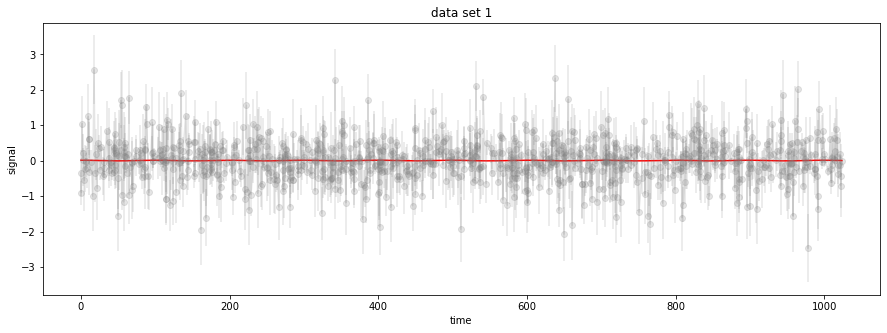

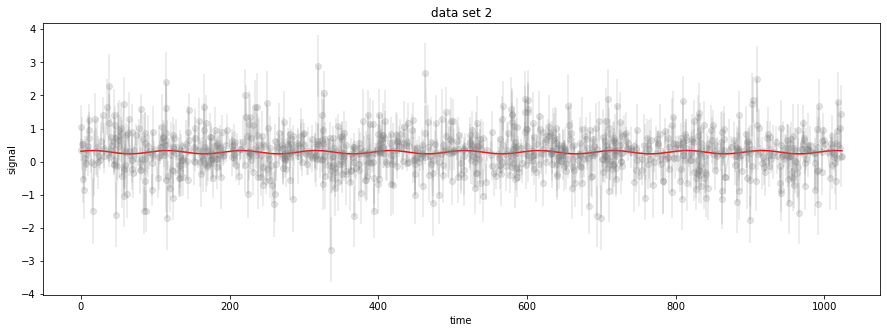

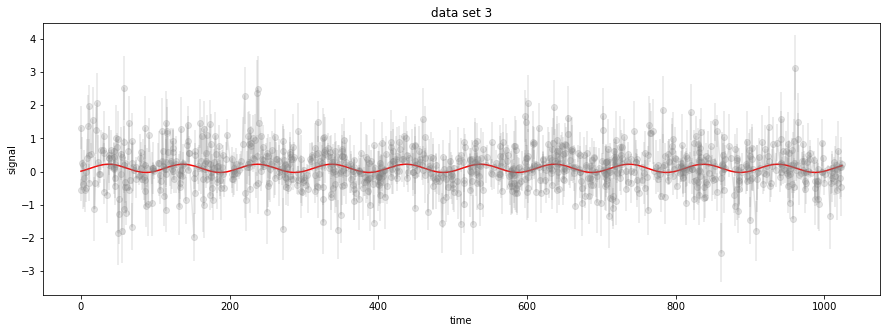

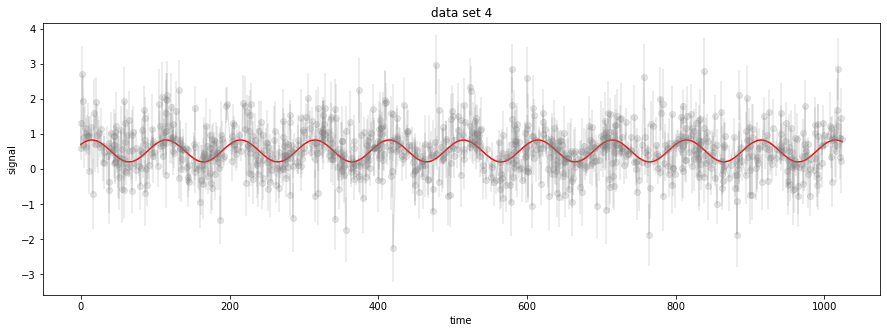

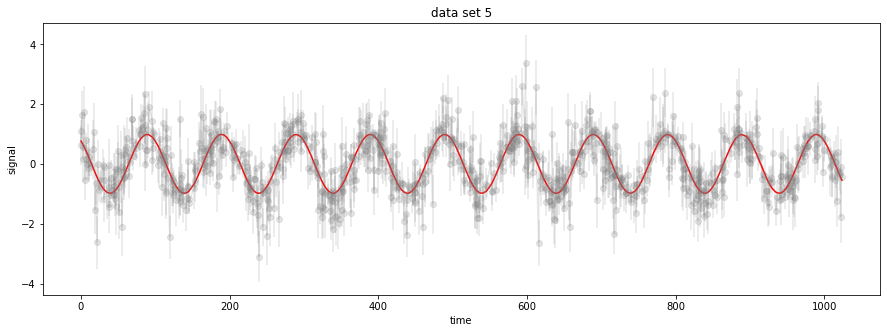

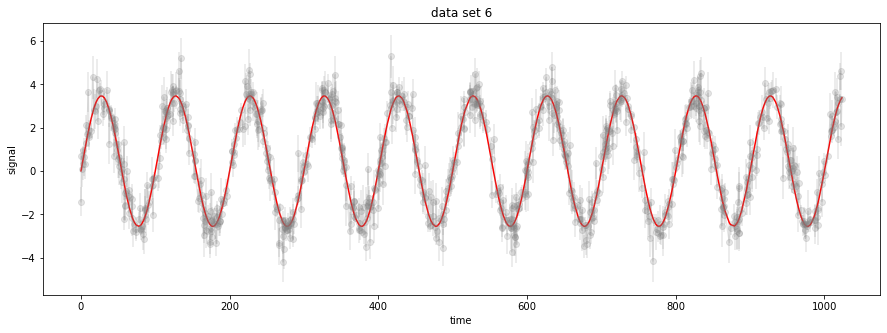

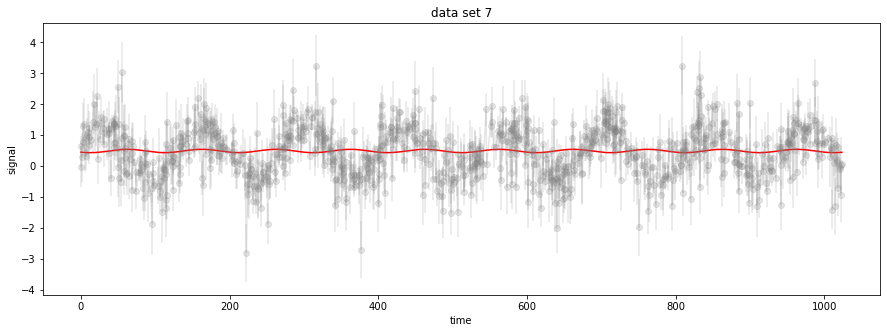

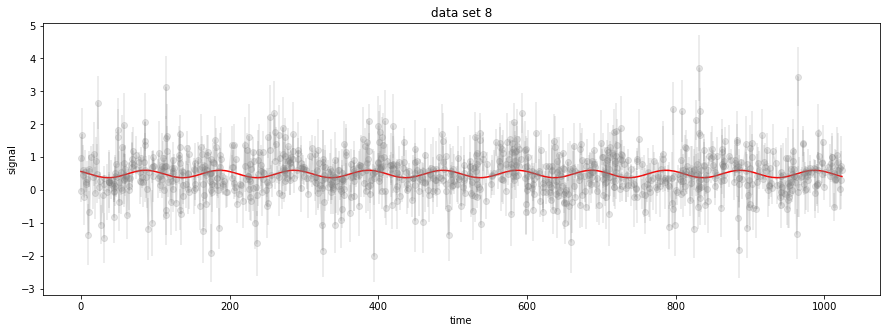

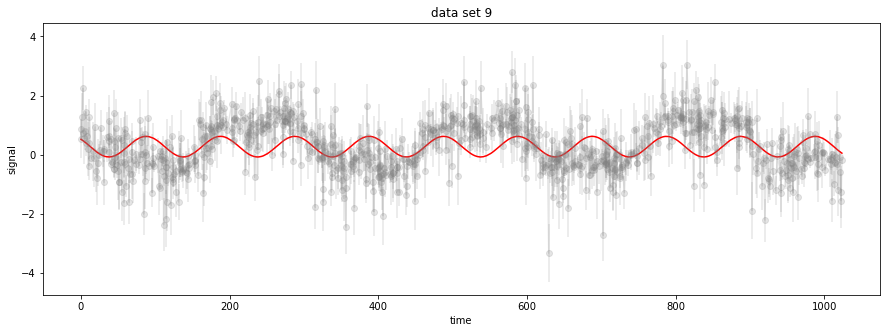

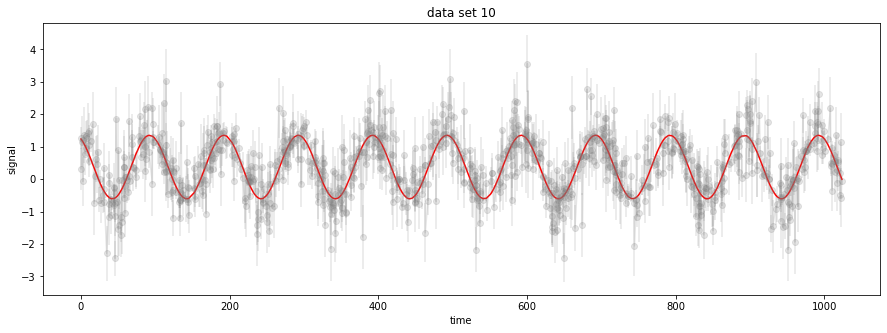

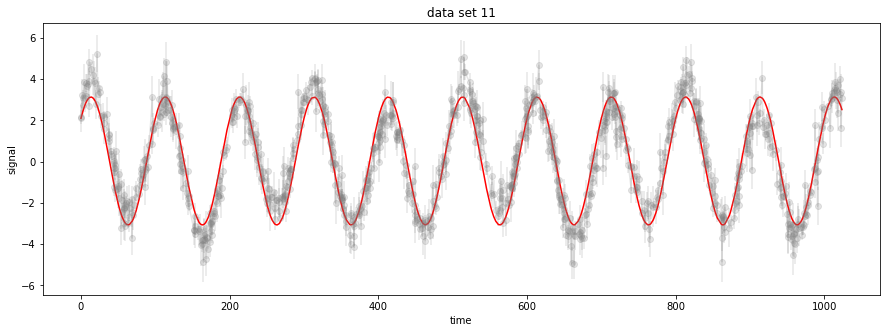

In [4]:
#Design 1 (Single 100-day sinusoid signal)
identity = lambda x: 1
cos100 = lambda x : np.cos((2*np.pi/100)*x)
sin100 = lambda x : np.sin((2*np.pi/100)*x)

#Calculating parameters of 100-day signals
par_vals1 = [designfit(data[0],data[i],data[1],cos100,sin100,identity) for i in range(2,13)]

#Calculating chi-squared values and plotting
chisq_0 = []

for i in range(2,13):
    y_pred_vals = par_vals1[i-2][0]*cos100(data[0])+par_vals1[i-2][1]*sin100(data[0])+par_vals1[i-2][2]
    delta_y = data[i] - y_pred_vals
    chisq_0.append(np.sum(delta_y*data[1]**(-2)*delta_y))
    
    #Plotting
    plt.figure(figsize=(15, 5))
    plt.errorbar(data[0], data[i], yerr=data[1],
                 color="gray", marker="o", alpha=0.2)
    plt.plot(data[0],par_vals1[i-2][0]*cos100(data[0])+par_vals1[i-2][1]*sin100(data[0])+par_vals1[i-2][2],color='red')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(i-1))

# Two signals

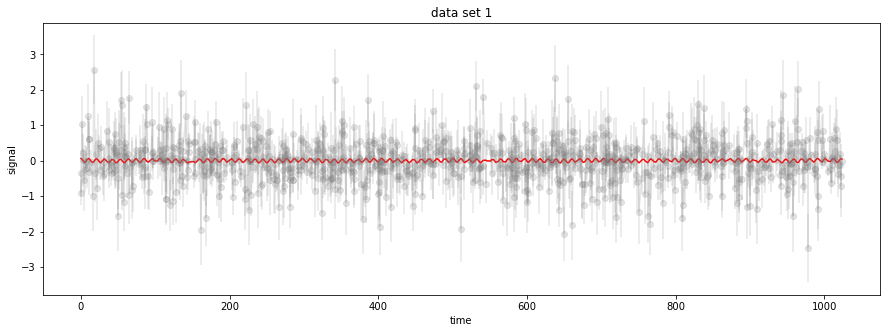

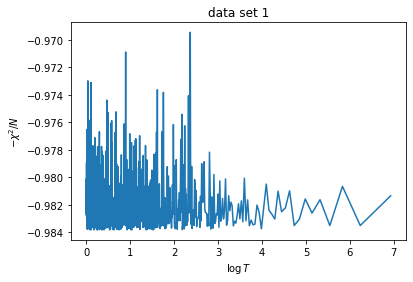

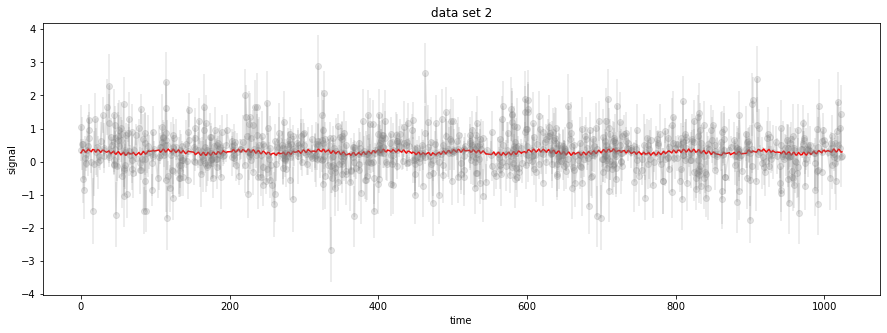

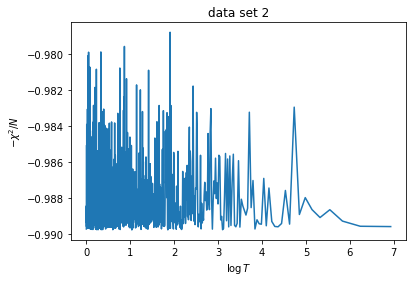

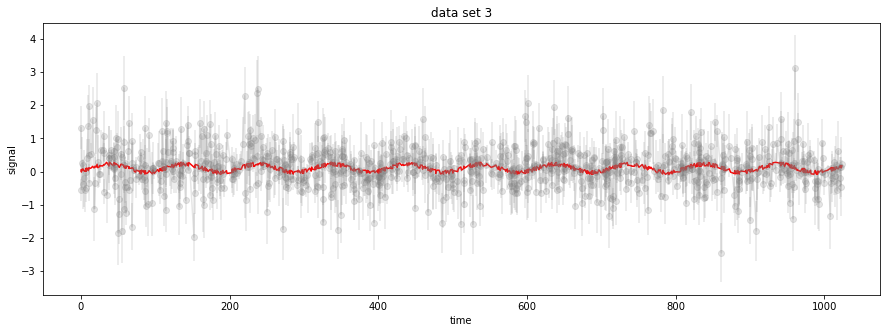

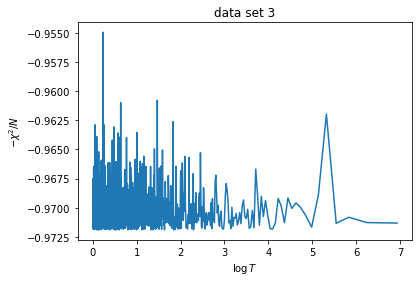

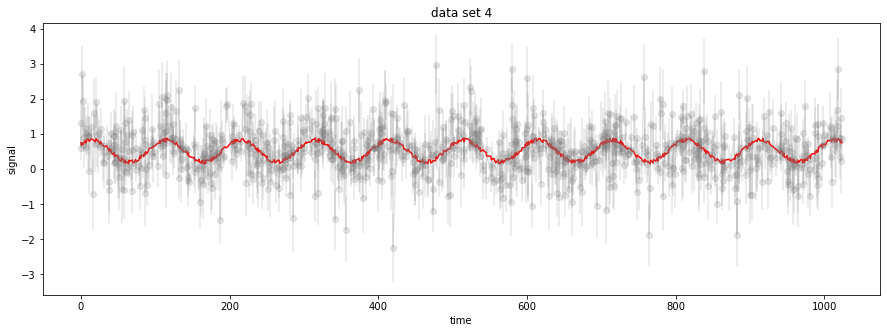

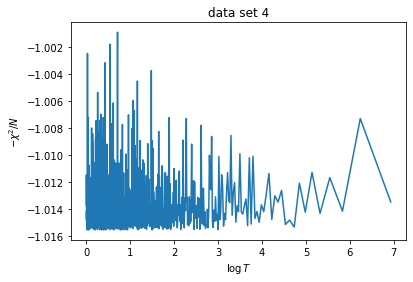

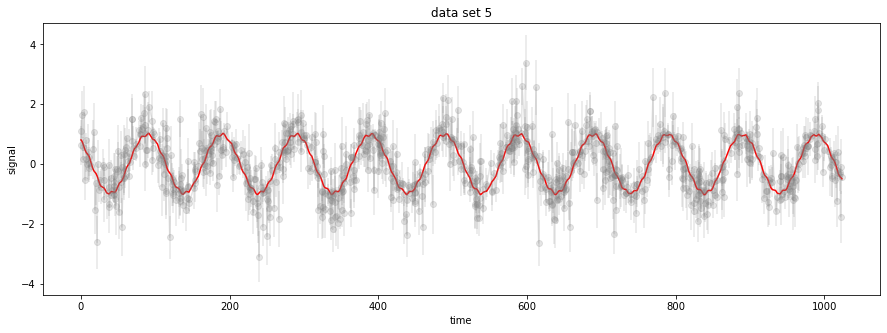

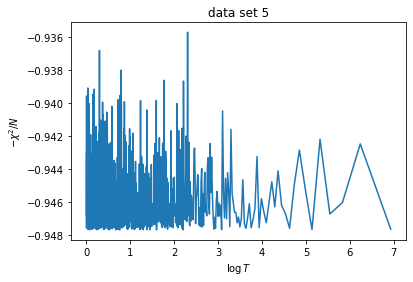

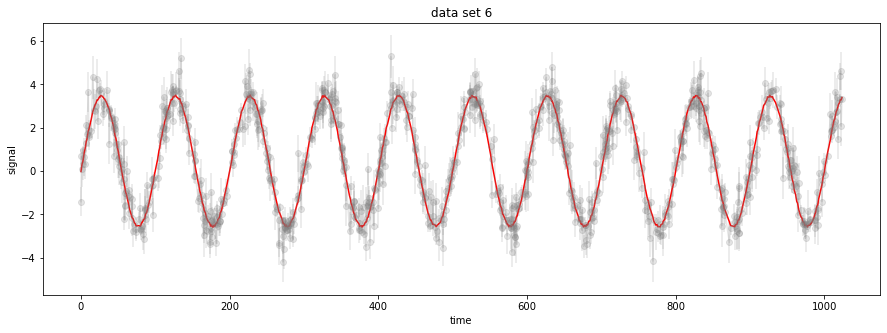

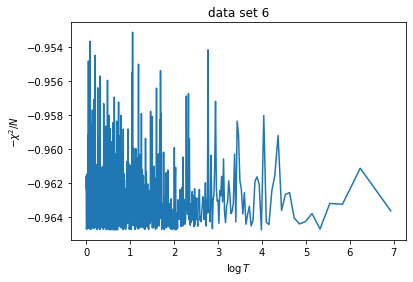

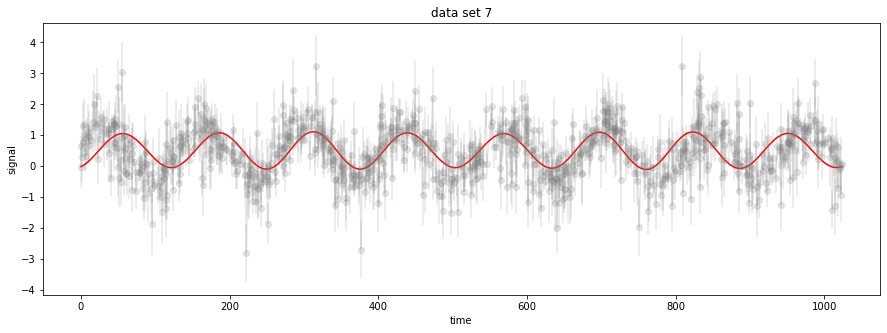

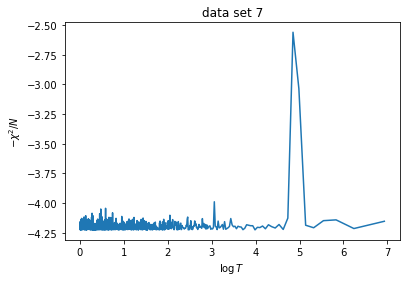

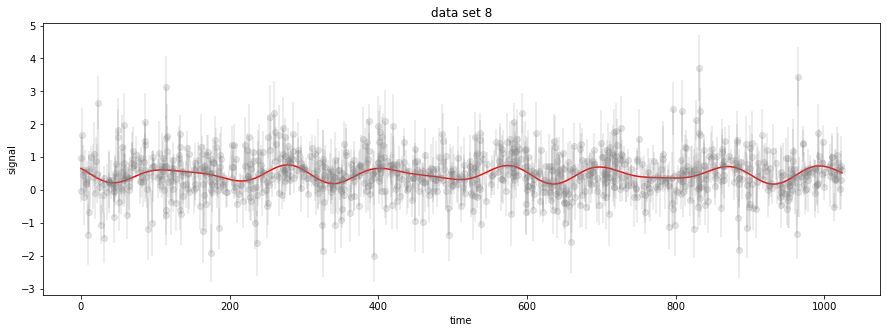

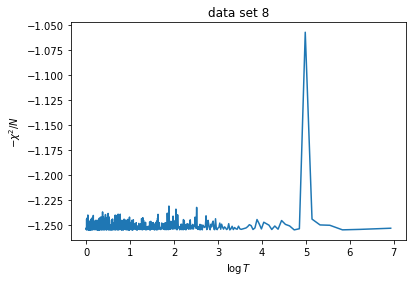

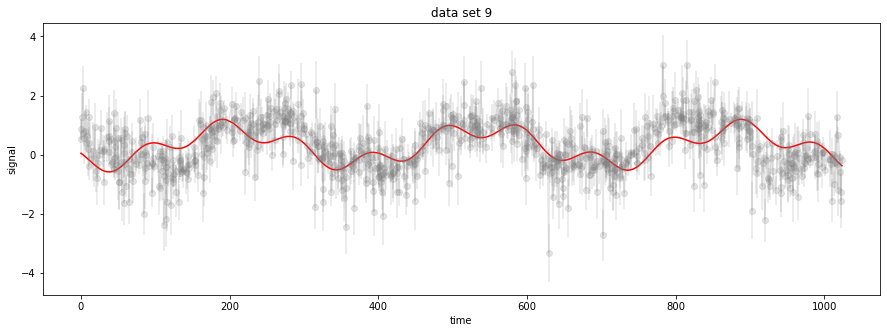

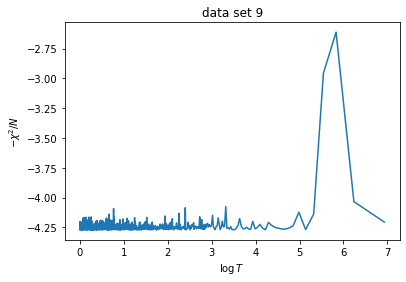

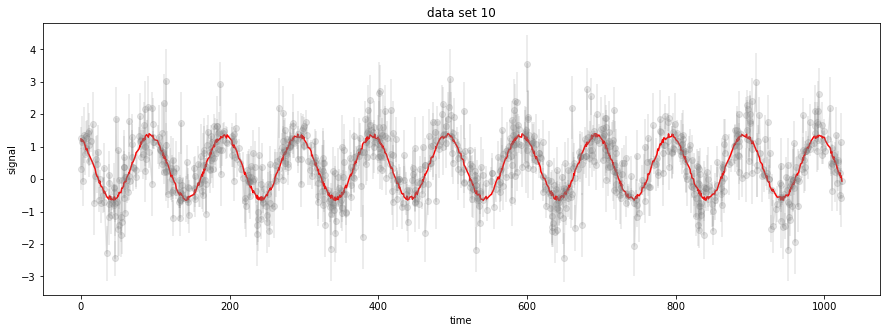

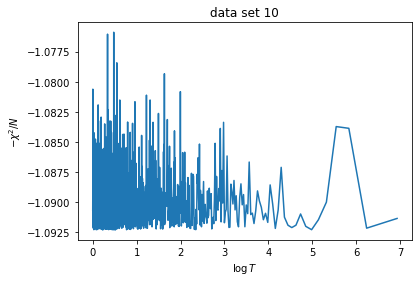

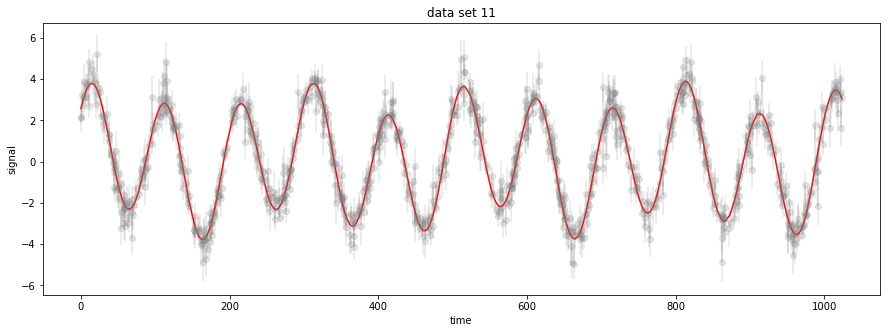

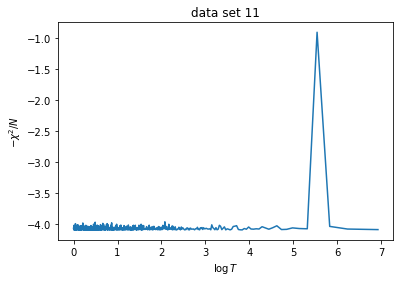

In [43]:
#Design 2 (100-day signal + one more signal)

#Knobs
sample_step = 1

#Gettin best-fits, chi-squared values, and plots
chisq = []

for data_set_index in range(2,13):

    #Setting up log likelihood sample space
    total_time = int(max(data[0])-min(data[0]))
    freq_samples = np.arange(sample_step,total_time+sample_step,sample_step)/total_time
    neg_chisq = []

    #Exploring the parameter space
    for f in freq_samples:
        sinvar = lambda x : np.sin(2*np.pi*f*x)
        cosvar = lambda x : np.cos(2*np.pi*f*x)

        par_vals2 = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvar,sinvar)

        y_pred_vals = par_vals2[0]*cos100(data[0]) + par_vals2[1]*sin100(data[0]) + par_vals2[2] + par_vals2[3]*cosvar(data[0]) + par_vals2[4]*sinvar(data[0])
        delta_y = data[data_set_index] - y_pred_vals
        neg_chisq.append(-np.sum(delta_y*data[1]**(-2)*delta_y))
    
    #Getting best fit
    freq_best = freq_samples[neg_chisq.index(max(neg_chisq))]
    sinvarbest = lambda x : np.sin(2*np.pi*freq_best*x)
    cosvarbest = lambda x : np.cos(2*np.pi*freq_best*x)
    par_vals2_best = designfit(data[0],data[data_set_index],data[1],cos100,sin100,identity,cosvarbest,sinvarbest)
    y_bestfit_vals = par_vals2_best[0]*cos100(data[0]) + par_vals2_best[1]*sin100(data[0]) + par_vals2_best[2] + par_vals2_best[3]*cosvarbest(data[0]) + par_vals2_best[4]*sinvarbest(data[0])
    delta_y = data[data_set_index] - y_bestfit_vals
    chisq.append(np.sum(delta_y*data[1]**(-2)*delta_y))

    #Plotting
    plt.figure(figsize=(15, 5))
    plt.errorbar(data[0], data[data_set_index], yerr=data[1],
                 color="gray", marker="o", alpha=0.2)
    plt.plot(data[0],y_bestfit_vals,color='red')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(data_set_index-1))
    plt.show()

    plt.plot(-np.log(freq_samples),np.array(neg_chisq)/len(data[0]))
    plt.ylabel('$-\chi^2/N$')
    plt.xlabel('$\log T$')
    plt.title(f'data set {data_set_index-1}')
    plt.show()

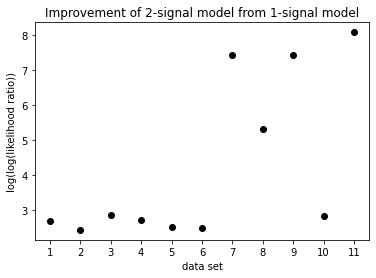

In [44]:
#Plotting likelihood ratios (Design 2 from Design 1)
plt.scatter(np.arange(1,12),np.log(np.array(chisq_0)-np.array(chisq)),color='black')
plt.xlabel('data set')
plt.ylabel('log(log(likelihood ratio))')
plt.xticks(np.arange(1,12))
plt.title('Improvement of 2-signal model from 1-signal model')
plt.show()

This graph shows the improvement of the double-signal model from the single-100-day-signal model in log(log(likelihood)). From this graph, it looks like data sets 7, 9, and 11 have 2 signals with an improvement ratio $\mathcal{L}_2/\mathcal{L}_1=e^{e^5}\approx 2.85\times 10^{64}$. In comparison, the improvement for the other signals is only around $\mathcal{L}_2/\mathcal{L}_1=e^{e^3}\approx 5.28\times 10^{8}$. **The values of the former set of data is separated to the latter by an order of magnitude of 56.** Also, the frequencies of the possible second signal of the latter set lie in the high-frequency range, which possibly already captures the fluctuations in the noise, not from the signal.

# Error analysis

In [41]:
#Bootstrap

bootstrap_samples = 40

amps = []
sigmasq = []

for data_set_index in range(2,13):
    print(f'Data set {data_set_index-1}...')
    
    amplitude_set = np.random.rand(bootstrap_samples)

    for boot_samp in range(bootstrap_samples):
        data_set_sample = np.array([data[:,int(np.random.random_sample()*len(data[0]))] for i in range(len(data[0]))]).transpose()

        freq_samples = np.arange(sample_step,total_time+sample_step,sample_step)/total_time
        chi_sq = []

        for f in freq_samples:
            sinvar = lambda x : np.sin(2*np.pi*f*x)
            cosvar = lambda x : np.cos(2*np.pi*f*x)

            par_vals2 = designfit(data_set_sample[0],data_set_sample[data_set_index],data_set_sample[1],cos100,sin100,identity,cosvar,sinvar)

            y_pred_vals = par_vals2[0]*cos100(data_set_sample[0]) + par_vals2[1]*sin100(data_set_sample[0]) + par_vals2[2] + par_vals2[3]*cosvar(data_set_sample[0]) + par_vals2[4]*sinvar(data_set_sample[0])
            delta_y = y_pred_vals - data_set_sample[data_set_index]
            chi_sq.append(-np.sum(delta_y*data_set_sample[1]**(-2)*delta_y)/2)

        freq_best = freq_samples[chi_sq.index(max(chi_sq))]
        sinvarbest = lambda x : np.sin(2*np.pi*freq_best*x)
        cosvarbest = lambda x : np.cos(2*np.pi*freq_best*x)
        par_vals2_best = designfit(data_set_sample[0],data_set_sample[data_set_index],data_set_sample[1],cos100,sin100,identity,cosvarbest,sinvarbest)

        amplitude_set[boot_samp] = np.sqrt(par_vals2_best[3]**2+par_vals2_best[4]**2)

        print(f'{boot_samp+1}/{bootstrap_samples}')
        
    amps.append(np.mean(amplitude_set))
    sigmasq.append(np.sqrt(np.mean((amplitude_set-np.mean(amplitude_set))**2)))

Data set 1...
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40
Data set 2...
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40
Data set 3...
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40
Data set 4...
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40
Data set 5...
1/40
2

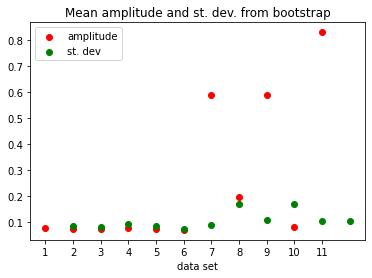

In [20]:
#Plotting results
plt.scatter(np.arange(1,12),amps,color='red',label='amplitude')
plt.scatter(np.arange(2,13),np.sqrt(np.array(sigmasq)),color='green',label='st. dev')
plt.title('Mean amplitude and st. dev. from bootstrap')
plt.xlabel('data set')
plt.xticks(np.arange(1,12))
plt.legend()
plt.show()

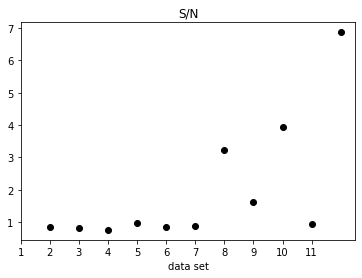

In [42]:
#Getting S/Ns
plt.scatter(np.arange(2,13),np.array(amps)/np.sqrt(np.array(sigmasq)),color='black')
plt.title('S/N')
plt.xlabel('data set')
plt.xticks(np.arange(1,12))
plt.show()